In [1]:
import matplotlib.pyplot as pt
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')

In [2]:
#locally weighted regression
def lwr(inp, out, k):
    m,n = np.shape(inp)
    ypred = np.zeros(m)    
    for i in range(m):
        ypred[i] = inp[i] * beta(inp[i], inp, out, k)
    #print("The final prediction is :",ypred)
    return ypred

def lwr1(x0, inp, out, k):
    m,n = np.shape(inp)
    ypred = np.zeros(m)    
    ypred = x0 * beta(x0, inp, out, k)
    #print("The final prediction is :",ypred)
    return ypred

def beta(point, inp, out, k):
    wt = kernal(point, inp, k)
    #print("The weight of betas is",wt)
    #print("Weight * inp" , (inp.T * (wt*inp)).I)
    out = out.reshape((inp.shape[0],1))
#     print(inp.shape)
#     print(wt.shape)
#     print(out.shape)
    beta_val = (inp.T * (wt*inp)).I * inp.T * wt * out
    #print("The weight is beta value is",beta_val)
    return beta_val

def kernal(point, inp, k):
    l,b = np.shape(inp)
    weights = np.mat(np.eye((l)))
    #print(weights)    
    for i in range(l):
        #point = point.reshape((point.shape[0],1))
        #print(point.shape,inp[i].shape)
        diff = point - inp[i]
        #print(diff.shape)
        weights[i,i] = np.exp(np.dot(diff,diff.T) / (-2.0 * (k**2)))
    return weights

In [3]:
mpl.rcParams['figure.figsize'] = (18, 6)
mpl.rcParams['axes.grid'] = True

In [752]:
def sense_val_inflow(df):
    sense_vals = []
    for x in df['Inflow']:
        if(x <= 50):
            sense_vals.append(int(1))
        if((x > 50) and (x<=100)):
            sense_vals.append(int(2))    
        if((x > 100) and (x<=500)):
            sense_vals.append(int(3))
        if((x > 500) and (x<=1000)):
            sense_vals.append(int(4))
        if((x > 1000) and (x <= 2000)):
            sense_vals.append(int(5))
        if((x > 2000) and (x<=3000)):
            sense_vals.append(int(6))
        if((x > 3000) and (x <= 4000)):
            sense_vals.append(int(7))
        if((x > 4000) and (x <= 5000)):
            sense_vals.append(int(8))
        if((x > 5000) and (x <= 6000)):
            sense_vals.append(int(9))
        if((x > 6000) and (x <= 7000)):
            sense_vals.append(int(10))
        if((x > 7000) and (x <= 8000)):
            sense_vals.append(int(11))
        if((x > 8000) and (x <= 9000)):
            sense_vals.append(int(12))
        if((x > 9000) and (x <= 10000)):
            sense_vals.append(int(13))
        if((x > 10000) and (x <= 15000)):
            sense_vals.append(int(14))
        if((x > 15000) and (x <= 20000)):
            sense_vals.append(int(15))
        if((x > 20000) and (x <= 30000)):
            sense_vals.append(int(16))
        if((x > 30000) and (x <= 40000)):
            sense_vals.append(int(17))
        if((x > 40000) and (x <= 60000)):
            sense_vals.append(int(18))
        if((x > 60000) and (x <= 70000)):
            sense_vals.append(int(19))
        if(x > 70000):
            sense_vals.append(int(20))
    return sense_vals

In [661]:
# def sense_val_inflow(df):
#     sense_vals = []
#     for x in df['Inflow']:
#         if(x <= 500):
#             sense_vals.append(int(1))
#         if((x > 500) and (x<=1000)):
#             sense_vals.append(int(2))    
#         if((x > 1000) and (x<=5000)):
#             sense_vals.append(int(3))
#         if((x > 5000) and (x<=10000)):
#             sense_vals.append(int(4))
#         if(x > 10000):
#             sense_vals.append(int(5))
# #         if((x > 2000) and (x<=3000)):
# #             sense_vals.append(int(6))
# #         if((x > 3000) and (x <= 4000)):
# #             sense_vals.append(int(7))
# #         if((x > 4000) and (x <= 5000)):
# #             sense_vals.append(int(8))
# #         if((x > 5000) and (x <= 6000)):
# #             sense_vals.append(int(9))
# #         if((x > 6000) and (x <= 7000)):
# #             sense_vals.append(int(10))
# #         if((x > 7000) and (x <= 8000)):
# #             sense_vals.append(int(11))
# #         if((x > 8000) and (x <= 9000)):
# #             sense_vals.append(int(12))
# #         if((x > 9000) and (x <= 10000)):
# #             sense_vals.append(int(13))
# #         if((x > 10000) and (x <= 15000)):
# #             sense_vals.append(int(14))
# #         if((x > 15000) and (x <= 20000)):
# #             sense_vals.append(int(15))
# #         if((x > 20000) and (x <= 30000)):
# #             sense_vals.append(int(16))
# #         if((x > 30000) and (x <= 40000)):
# #             sense_vals.append(int(17))
# #         if((x > 40000) and (x <= 60000)):
# #             sense_vals.append(int(18))
# #         if((x > 60000) and (x <= 70000)):
# #             sense_vals.append(int(19))
# #         if(x > 70000):
# #             sense_vals.append(int(20))
#     return sense_vals

In [662]:
# def sense_val_avg(df):
#     sense_vals = []
#     for x in df['Avg']:
#         if(x == 0):
#             sense_vals.append(float(1))
#         if((x > 0) and (x <= 1)):
#             sense_vals.append(float(2))
#         if((x > 1) and (x <= 2)):
#             sense_vals.append(float(3))
#         if((x > 2) and (x <= 3)):
#             sense_vals.append(float(4))
#         if((x > 3) and (x <= 4)):
#             sense_vals.append(float(5))
#         if((x > 4) and (x <= 5)):
#             sense_vals.append(float(6))
#         if((x > 5) and (x <= 6)):
#             sense_vals.append(float(7))
#         if((x > 6) and (x< 7)):
#             sense_vals.append(float(8))
#         if((x > 7) and (x <= 8)):
#             sense_vals.append(float(9))
#         if((x > 8) and (x <= 9)):
#             sense_vals.append(float(10))
#         if((x > 9) and (x <= 10)):
#             sense_vals.append(float(11))
#         if((x > 10) and (x <= 20)):
#             sense_vals.append(float(12))
#         if((x > 20) and (x <= 30)):
#             sense_vals.append(float(13))
#         if((x > 30) and (x <= 40)):
#             sense_vals.append(float(14))
#         if((x > 40) and (x <= 50)):
#             sense_vals.append(float(15))
#         if((x > 50) and (x <= 60)):
#             sense_vals.append(float(16))
#         if((x > 60) and (x <= 80)):
#             sense_vals.append(float(17))
#         if((x > 80) and (x <= 100)):
#             sense_vals.append(float(18))
#         if((x > 100) and (x <= 120)):
#             sense_vals.append(float(19))
#         if(x > 120):
#             sense_vals.append(float(20))
#     return sense_vals

In [753]:
#dataset preparation with lag
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [952]:
lag_val = 9

In [996]:
df = pd.read_csv('allYearLabeledHarangi.csv')
df
a = "RCDATE"
b = "Dates"
df['month'] = pd.DatetimeIndex(df[b]).month
df['year'] = pd.DatetimeIndex(df[b]).year
df = df.sort_values(by = ['month','Dates'])
mask = (df['month'] <= 12)#&(df['month'] >=6))
mask1 = (df['year'] <= 2017)
df = df.loc[mask]
df = df.loc[mask1]
df.drop(['Label'],axis = 1,inplace = True)
#df['Avg'] = (df['MADIKERI']+df['SOMWARPET']+df['VIRAJPET'])/3
#df.to_csv(r"/home/ganesh/Downloads/avg_added_pred.csv")
df.set_index(b,inplace = True)
#df.to_csv(r"/home/ganesh/Downloads/avg_added_pred.csv")     
dataframe = pd.DataFrame(df, columns = ['MADIKERI', 'SOMWARPET', 'VIRAJPET'])
dataframe["minimum"] = dataframe.min(axis = 1)
df.drop(['month','year',"Present Storage(TMC)",'Reservoir Level(TMC)','Outflow'],axis = 1,inplace = True)
#df.drop(['Inflow'],axis = 1,inplace = True)
df['Inflow_Label'] = sense_val_inflow(df)
#df['Rainfall_Label'] = sense_val_avg(df)
#df['Mul'] = df['Inflow_Label'] * df['Rainfall_Label']
#df.to_csv(r"/home/ganesh/Downloads/avg1_added_pred.csv") 
#df.drop(['Avg','Inflow_Label'],axis = 1,inplace = True)
#df['Inflow_Label'] = sense_val_inflow(df)
# count = df['Label'].value_counts()
df.drop(['Inflow'],axis = 1,inplace = True)
#count
df

,MADIKERI,SOMWARPET,VIRAJPET,Inflow_Label
Dates,,,,
2011-01-01,0.000000,0.000000,0.0,3
2011-01-02,0.000000,0.000000,0.0,3
2011-01-03,0.000000,0.000000,0.0,3
2011-01-04,0.000000,0.000000,0.0,3
2011-01-05,0.000000,0.000000,0.0,3
...,...,...,...,...
2017-12-27,0.036796,0.847864,0.0,3
2017-12-28,0.037441,0.862739,0.0,3
2017-12-29,0.038087,0.877613,0.0,3


In [997]:
values = df.values
values = values.astype('float64')
# normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)
# data=pd.DataFrame({'Inflow':scaled[:,0],'MADIKERI':scaled[:,1],'SOMWARPET':scaled[:,2],'VIRAJPET':scaled[:,3]})
# print(data.shape)
# idx = pd.date_range('2011-01-01', '2011-12-31') 
# data.set_index(idx)
# frame as supervised learning
reframed = series_to_supervised(values, lag_val,1)#lag of 4 days
# drop columns we don't want to predict
reframed.drop(reframed.columns[[]], axis=1, inplace=True)
reframed


,var1(t-9),var2(t-9),var3(t-9),var4(t-9),var1(t-8),var2(t-8),var3(t-8),var4(t-8),var1(t-7),var2(t-7),...,var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
9,0.000000,0.000000,0.0,3.0,0.000000,0.000000,0.0,3.0,0.000000,0.000000,...,0.0,3.0,0.000000,0.000000,0.0,3.0,0.000000,0.000000,0.0,3.0
10,0.000000,0.000000,0.0,3.0,0.000000,0.000000,0.0,3.0,0.000000,0.000000,...,0.0,3.0,0.000000,0.000000,0.0,3.0,0.000000,0.000000,0.0,3.0
11,0.000000,0.000000,0.0,3.0,0.000000,0.000000,0.0,3.0,0.000000,0.000000,...,0.0,3.0,0.000000,0.000000,0.0,3.0,0.000000,0.000000,0.0,2.0
12,0.000000,0.000000,0.0,3.0,0.000000,0.000000,0.0,3.0,0.000000,0.000000,...,0.0,3.0,0.000000,0.000000,0.0,2.0,0.000000,0.000000,0.0,2.0
13,0.000000,0.000000,0.0,3.0,0.000000,0.000000,0.0,3.0,0.000000,0.000000,...,0.0,2.0,0.000000,0.000000,0.0,2.0,0.000000,0.000000,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,0.030986,0.713991,0.0,2.0,0.031631,0.728865,0.0,2.0,0.032277,0.743740,...,0.0,3.0,0.036150,0.832989,0.0,3.0,0.036796,0.847864,0.0,3.0
2553,0.031631,0.728865,0.0,2.0,0.032277,0.743740,0.0,2.0,0.032923,0.758615,...,0.0,3.0,0.036796,0.847864,0.0,3.0,0.037441,0.862739,0.0,3.0
2554,0.032277,0.743740,0.0,2.0,0.032923,0.758615,0.0,3.0,0.033568,0.773490,...,0.0,3.0,0.037441,0.862739,0.0,3.0,0.038087,0.877613,0.0,3.0
2555,0.032923,0.758615,0.0,3.0,0.033568,0.773490,0.0,3.0,0.034214,0.788365,...,0.0,3.0,0.038087,0.877613,0.0,3.0,0.038732,0.892488,0.0,3.0


In [998]:
# colA = np.array(data.loc[:,['MADIKERI','SOMWARPET','VIRAJPET']])
# colB = np.array(data['Inflow'])

# l,b = np.shape(colA)
# l,b
# print(np.shape(colA))
# print(np.shape(colB))
# colA
# colB = colB.T
# t_vals = []
# for i in range(l):
#     a = colA[i]
#     b = colB[i]
#     t_vals.append((a,b))
# #t_vals = np.array(t_vals)
# print(t_vals)
# np.shape(t_vals)


In [999]:
values = reframed.values
#np.random.shuffle(values)
train_x = values[:,:-1]
#print(train_x)
train_y = values[:,-1].astype(int)
train_y = train_y.reshape((train_x.shape[0],1))
print(train_x.shape)
print(train_y.shape)
train_x.shape
inp = values
train_x
train_y

(2548, 39)
(2548, 1)


array([[3],
       [3],
       [2],
       ...,
       [3],
       [3],
       [3]])

In [1000]:
df1 = pd.read_csv('allYearLabeledHarangi.csv')
df1
a = "RCDATE"
b = "Dates"
df1['month'] = pd.DatetimeIndex(df1[b]).month
df1['year'] = pd.DatetimeIndex(df1[b]).year
mask = (df1['month'] <= 12)#&(df1['month'] >=1))
mask1 = (df1['year'] > 2017 )
df1 = df1.loc[mask]
df1 = df1.loc[mask1]
df1.drop(['Label'],axis = 1,inplace = True)
#df1['Avg'] = (df1['MADIKERI']+df1['SOMWARPET']+df1['VIRAJPET'])/3
#df.to_csv(r"/home/ganesh/Downloads/avg_added_pred.csv")
df1.set_index(b,inplace = True)
#df.to_csv(r"/home/ganesh/Downloads/avg_added_pred.csv")     
dataframe = pd.DataFrame(df1, columns = ['MADIKERI', 'SOMWARPET', 'VIRAJPET'])
dataframe["minimum"] = dataframe.min(axis = 1)
df1.drop(['month','year',"Present Storage(TMC)",'Reservoir Level(TMC)','Outflow'],axis = 1,inplace = True)
#df.drop(['Inflow'],axis = 1,inplace = True)
df1['Inflow_Label'] = sense_val_inflow(df1)
#df1['Rainfall_Label'] = sense_val_avg(df1)
#df1['mul'] = df1['Inflow_Label'] * df1['Rainfall_Label']
#df.to_csv(r"/home/ganesh/Downloads/avg1_added_pred.csv") 
#df1.drop(['Avg','Inflow_Label'],axis = 1,inplace = True)
#df1['Inflow_Label'] = sense_val_inflow(df1)
df1.drop(['Inflow'],axis = 1,inplace = True)
df1.head(50)
# count = df1['Label'].value_counts()
# count

,MADIKERI,SOMWARPET,VIRAJPET,Inflow_Label
Dates,,,,
2018-01-01,0.040023,0.922238,0.0,3
2018-01-02,0.040669,0.937113,0.0,3
2018-01-03,0.041315,0.951987,0.0,3
2018-01-04,0.041960,0.966862,0.0,3
2018-01-05,0.042606,0.981737,0.0,3
2018-01-06,0.043251,0.996612,0.0,3
2018-01-07,0.043897,1.011487,0.0,3
2018-01-08,0.044542,1.026362,0.0,3
2018-01-09,0.045188,1.041236,0.0,3


In [1001]:
values1 = df1.values
values1 = values1.astype('float64')
# normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values1)
# data1=pd.DataFrame({'Inflow':scaled[:,0],'MADIKERI':scaled[:,1],'SOMWARPET':scaled[:,2],'VIRAJPET':scaled[:,3]})
# print(data1.shape)
# idx = pd.date_range('2012-01-01', '2018-12-31') 
# data1.set_index(idx)
# frame as supervised learning
reframed1 = series_to_supervised(values1, lag_val, 1)#lag of 4 days
# drop columns we don't want to predict1
reframed1.head()
reframed1.drop(reframed1.columns[[]], axis=1, inplace=True)
#np.random.shuffle(reframed1)
reframed1

,var1(t-9),var2(t-9),var3(t-9),var4(t-9),var1(t-8),var2(t-8),var3(t-8),var4(t-8),var1(t-7),var2(t-7),...,var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
9,0.040023,0.922238,0.0,3.0,0.040669,0.937113,0.0,3.0,0.041315,0.951987,...,0.0,3.0,0.045188,1.041236,0.0,3.0,0.045833,1.056111,0.0,3.0
10,0.040669,0.937113,0.0,3.0,0.041315,0.951987,0.0,3.0,0.041960,0.966862,...,0.0,3.0,0.045833,1.056111,0.0,3.0,0.046479,1.070986,0.0,3.0
11,0.041315,0.951987,0.0,3.0,0.041960,0.966862,0.0,3.0,0.042606,0.981737,...,0.0,3.0,0.046479,1.070986,0.0,3.0,0.047124,1.085861,0.0,3.0
12,0.041960,0.966862,0.0,3.0,0.042606,0.981737,0.0,3.0,0.043251,0.996612,...,0.0,3.0,0.047124,1.085861,0.0,3.0,0.047770,1.100736,0.0,3.0
13,0.042606,0.981737,0.0,3.0,0.043251,0.996612,0.0,3.0,0.043897,1.011487,...,0.0,3.0,0.047770,1.100736,0.0,3.0,0.048415,1.115610,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.000000,0.000000,0.0,2.0,0.000000,0.000000,0.0,2.0,0.000000,0.000000,...,0.0,3.0,0.000000,0.000000,0.0,2.0,0.000000,0.000000,0.0,3.0
361,0.000000,0.000000,0.0,2.0,0.000000,0.000000,0.0,2.0,0.000000,0.000000,...,0.0,2.0,0.000000,0.000000,0.0,3.0,0.000000,0.000000,0.0,2.0
362,0.000000,0.000000,0.0,2.0,0.000000,0.000000,0.0,2.0,0.000000,0.000000,...,0.0,3.0,0.000000,0.000000,0.0,2.0,0.000000,0.000000,0.0,3.0
363,0.000000,0.000000,0.0,2.0,0.000000,0.000000,0.0,2.0,0.000000,0.000000,...,0.0,2.0,0.000000,0.000000,0.0,3.0,0.000000,0.000000,0.0,2.0


In [1002]:
values1 = reframed1.values
print(values1)
#np.random.shuffle(values1)
print(values1)
test_y = values1[:,-1].astype(int)
test_x = values1[:,:-1]
test_y = test_y.reshape(test_x.shape[0],1) 
print(train_x.shape,train_y.shape)
print(test_x.shape)
print(test_y.shape)
#print(list(Actuall_inflow))
Q_point = values1
Q_point
values

[[0.04002347 0.92223787 0.         ... 1.05611111 0.         3.        ]
 [0.04066901 0.93711268 0.         ... 1.07098592 0.         3.        ]
 [0.04131455 0.95198748 0.         ... 1.08586072 0.         3.        ]
 ...
 [0.         0.         0.         ... 0.         0.         3.        ]
 [0.         0.         0.         ... 0.         0.         2.        ]
 [0.         0.         0.         ... 0.         0.         2.        ]]
[[0.04002347 0.92223787 0.         ... 1.05611111 0.         3.        ]
 [0.04066901 0.93711268 0.         ... 1.07098592 0.         3.        ]
 [0.04131455 0.95198748 0.         ... 1.08586072 0.         3.        ]
 ...
 [0.         0.         0.         ... 0.         0.         3.        ]
 [0.         0.         0.         ... 0.         0.         2.        ]
 [0.         0.         0.         ... 0.         0.         2.        ]]
(2548, 39) (2548, 1)
(356, 39)
(356, 1)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        3.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        3.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        2.        ],
       ...,
       [0.032277  , 0.74374022, 0.        , ..., 0.87761346, 0.        ,
        3.        ],
       [0.03292254, 0.75861502, 0.        , ..., 0.89248826, 0.        ,
        3.        ],
       [0.03356808, 0.77348983, 0.        , ..., 0.90736307, 0.        ,
        3.        ]])

In [1003]:
# def create_qry_point(start,end):
#     query_data = np.array(Rain_data.iloc[start:end,:],dtype = float)
#     return query_data
        #40
# q_point = create_qry_point(1000,2000)
# q_point = np.mat([[137.695,57.25,80.2333333333333,36179],[123.0475,76.86,78.515,33901]])
# print(q_point)
# print(len(q_point))
# q_point.shape

In [1004]:
print(Q_point.shape)
print(inp.shape)
inp

(356, 40)
(2548, 40)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        3.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        3.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        2.        ],
       ...,
       [0.032277  , 0.74374022, 0.        , ..., 0.87761346, 0.        ,
        3.        ],
       [0.03292254, 0.75861502, 0.        , ..., 0.89248826, 0.        ,
        3.        ],
       [0.03356808, 0.77348983, 0.        , ..., 0.90736307, 0.        ,
        3.        ]])

In [1005]:
# def euclid_dist(points, q_point):
#     mini = 100000000
#     store_point = 0
#     for point in points:
#         val = np.linalg.norm(point - q_point)
#         if(mini > val):
#             mini = val
#             store_point = point
#     return list(store_point)
    

In [1006]:
# distance = list()
# points = inp 
# for single_point in Q_point:
#     distance.append(euclid_dist(points,single_point))

In [1007]:
# distance = np.array(distance)
# distance
# train_knn_y = distance[:,-1]
# train_knn_x = distance[:,:-1]
# print(train_knn_y.shape)
# print(train_knn_x.shape)
# train_knn_y

In [965]:
# def sense_val_inflow(df):
#     sense_vals = []
#     for x in df['Inflow']:
#         if(x <= 50):
#             sense_vals.append(int(1))
#         if((x > 50) and (x<=100)):
#             sense_vals.append(int(2))    
#         if((x > 100) and (x<=500)):
#             sense_vals.append(int(3))
#         if((x > 500) and (x<=1000)):
#             sense_vals.append(int(4))
#         if((x > 1000) and (x <= 2000)):
#             sense_vals.append(int(5))
#         if((x > 2000) and (x<=3000)):
#             sense_vals.append(int(6))
#         if((x > 3000) and (x <= 4000)):
#             sense_vals.append(int(7))
#         if((x > 4000) and (x <= 5000)):
#             sense_vals.append(int(8))
#         if((x > 5000) and (x <= 6000)):
#             sense_vals.append(int(9))
#         if((x > 6000) and (x <= 7000)):
#             sense_vals.append(int(10))
#         if((x > 7000) and (x <= 8000)):
#             sense_vals.append(int(11))
#         if((x > 8000) and (x <= 9000)):
#             sense_vals.append(int(12))
#         if((x > 9000) and (x <= 10000)):
#             sense_vals.append(int(13))
#         if((x > 10000) and (x <= 15000)):
#             sense_vals.append(int(14))
#         if((x > 15000) and (x <= 20000)):
#             sense_vals.append(int(15))
#         if((x > 20000) and (x <= 30000)):
#             sense_vals.append(int(16))
#         if((x > 30000) and (x <= 40000)):
#             sense_vals.append(int(17))
#         if((x > 40000) and (x <= 60000)):
#             sense_vals.append(int(18))
#         if((x > 60000) and (x <= 70000)):
#             sense_vals.append(int(19))
#         if(x > 70000):
#             sense_vals.append(int(20))
#     return sense_vals

In [941]:
# (10+14+14+8)/4
# #If lag 4 then k = 10
# #40.97,16.0483333333333,63.7666666666667,8,68.6025,20.9833333333333,51.32,10,

In [942]:


# new_val = [119.3225,48.6916666666667,89.4166666666667,14,55.0475,51.4666666666667,39.0433333333333,14,53.53,11.1283333333333,7.14833333333333]
# new_val = np.array(new_val)
# new_val.shape
# abc = lwr1(new_val,train_x,train_y,100)
# abc = np.round(abc)
# abc
# # train_x = train_knn_x
# # train_y = train_knn_y

In [993]:
#Logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class="multinomial",solver='saga',max_iter=10000,penalty="elasticnet")
lr.fit(train_x,train_y)
ypred = lr.predict(test_x)
Actuall_inflow=test_y.reshape(test_y.shape[0],1)
print("F1 Score = ",metrics.f1_score(Actuall_inflow[:],ypred[:],average = 'weighted'))
print("Precision = ",metrics.precision_score(Actuall_inflow[:],ypred[:],average = 'weighted'))
print("Recall = ",metrics.recall_score(Actuall_inflow[:],ypred[:],average = 'weighted'))
pt.plot(ypred[:],c='red')
pt.plot(Actuall_inflow[:],c='blue')

ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

F1 Score =  0.7323069427671153
Precision =  0.6679761188532348
Recall =  0.6713483146067416


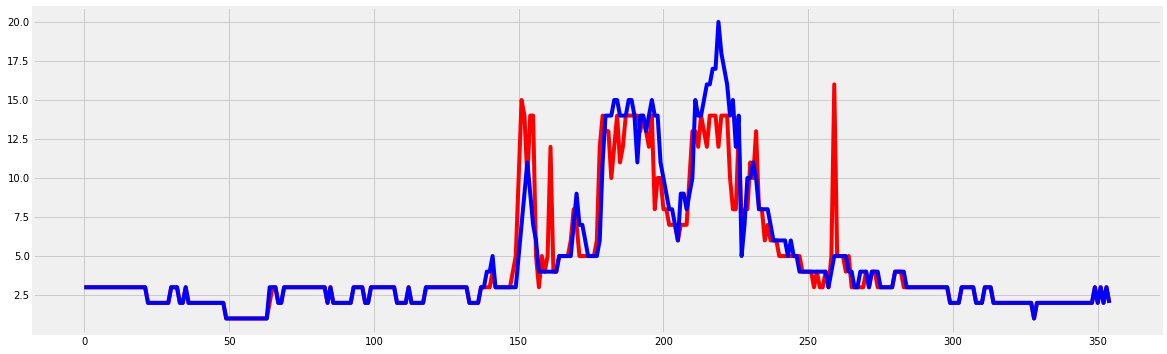

In [990]:
print("F1 Score = ",metrics.f1_score(Actuall_inflow[:-1],ypred[1:],average = 'weighted'))
print("Precision = ",metrics.precision_score(Actuall_inflow[:],ypred[:],average = 'weighted'))
print("Recall = ",metrics.recall_score(Actuall_inflow[:],ypred[:],average = 'weighted'))
pt.plot(ypred[1:],c='red')
pt.plot(Actuall_inflow[:-1],c='blue')

In [812]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(train_x,train_y)
ypred = nb.predict(test_x)

/home/ganesh/PycharmProjects/untitled1/venv/lib/python3.7/site-packages/sklearn/naive_bayes.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


F1 Score =  0.2750729496492208
Precision =  0.4043650793650793
Recall =  0.26666666666666666


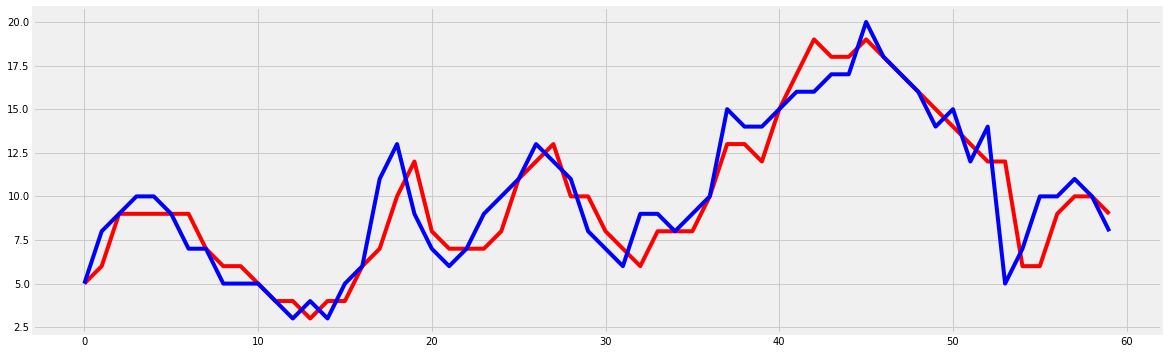

In [880]:
Actuall_inflow=test_y.reshape(test_y.shape[0],1)
print("F1 Score = ",metrics.f1_score(Actuall_inflow[:-1],ypred[1:],average = 'weighted'))
print("Precision = ",metrics.precision_score(Actuall_inflow[:],ypred[:],average = 'weighted'))
print("Recall = ",metrics.recall_score(Actuall_inflow[:],ypred[:],average = 'weighted'))
pt.plot(ypred[:],c='red')
pt.plot(Actuall_inflow[:],c='blue')

F1 Score =  0.22423910349808754
Precision =  0.3125184309638442
Recall =  0.23763736263736263


/home/ganesh/PycharmProjects/untitled1/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ganesh/PycharmProjects/untitled1/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


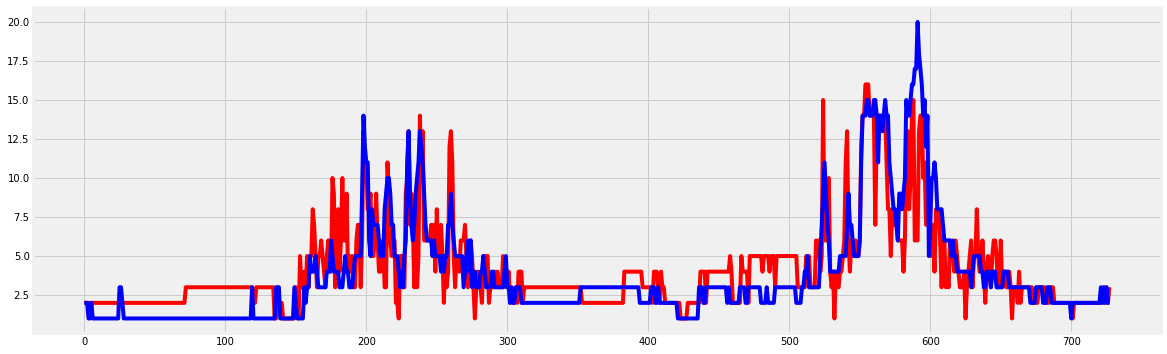

In [816]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_x,train_y)
ypred = knn.predict(test_x)
Actuall_inflow=test_y.reshape(test_y.shape[0],1)
print("F1 Score = ",metrics.f1_score(Actuall_inflow[:],ypred[:],average = 'weighted'))
print("Precision = ",metrics.precision_score(Actuall_inflow[:],ypred[:],average = 'weighted'))
print("Recall = ",metrics.recall_score(Actuall_inflow[:],ypred[:],average = 'weighted'))
pt.plot(ypred[:],c='red')
pt.plot(Actuall_inflow[:],c='blue')

MSE =  2.4171550671550674
RMSE =  1.554720253664648


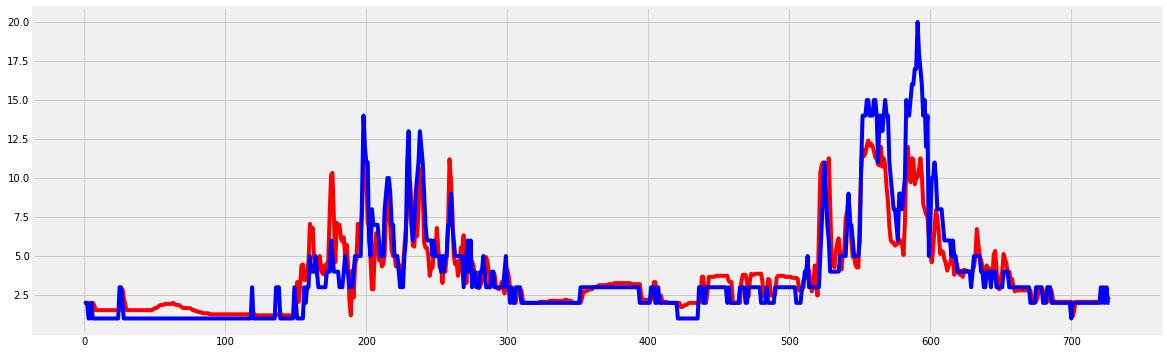

In [823]:
from sklearn.neighbors import KNeighborsRegressor
neigh_reg = KNeighborsRegressor(n_neighbors=15)
neigh_reg.fit(train_x,train_y)
ypred = neigh_reg.predict(test_x)
Actuall_inflow=test_y.reshape(test_y.shape[0],1)
print("MSE = ",metrics.mean_squared_error(Actuall_inflow,ypred))
#print("RMSE = ",sqrt(metrics.mean_squared_error(Actuall_inflow,train_knn_y)))
print("RMSE = ",sqrt(metrics.mean_squared_error(Actuall_inflow,ypred)))
#print("F1 Score = ",metrics.f1_score(Actuall_inflow[:],ypred[:],average = 'weighted'))
# print("Precision = ",metrics.precision_score(Actuall_inflow[:],ypred[:],average = 'weighted'))
# print("Recall = ",metrics.recall_score(Actuall_inflow[:],ypred[:],average = 'weighted'))
pt.plot(ypred[:],c='red')
pt.plot(Actuall_inflow[:],c='blue')

In [806]:
ypred = []
# print(test_x.shape)
# print(train_knn_x.shape)
# print(train_knn_y.shape)
for i in test_x:
    ypred.append(lwr1(i, train_x, train_y, 50))
ypred = np.array(ypred).reshape(test_y.shape[0],1)

Actuall_inflow=test_y.reshape(test_y.shape[0],1)

In [807]:
ypred = np.round(ypred)
df3 = pd.DataFrame()
df3['predicted'] = list(ypred)
df3['Actuall'] = Actuall_inflow
df3.to_csv(r"/home/ganesh/Downloads/choice_added_pred.csv") 
#print((ypred,Actuall_inflow))

In [808]:
print("MSE = ",metrics.mean_squared_error(Actuall_inflow,ypred))
#print("RMSE = ",sqrt(metrics.mean_squared_error(Actuall_inflow,train_knn_y)))
print("RMSE = ",sqrt(metrics.mean_squared_error(Actuall_inflow,ypred)))
print("Accuracy = " ,metrics.accuracy_score(Actuall_inflow,ypred))
print("Accuracy_lag = " ,metrics.accuracy_score(Actuall_inflow[0:],ypred[:]))
#print("Accuracy_knn = " ,metrics.accuracy_score(Actuall_inflow,train_knn_y))
print("F1 Score = ",metrics.f1_score(Actuall_inflow[:-1],ypred[1:],average = 'weighted'))
print("Precision = ",metrics.precision_score(Actuall_inflow[:],ypred[:],average = 'weighted'))
print("Recall = ",metrics.recall_score(Actuall_inflow[:],ypred[:],average = 'weighted'))
print("F1 Score_no_lag = ",metrics.f1_score(Actuall_inflow,ypred,average = 'weighted'))

MSE =  0.7939560439560439
RMSE =  0.8910421112136305
Accuracy =  0.7005494505494505
Accuracy_lag =  0.7005494505494505
F1 Score =  0.8402928029556408
Precision =  0.7097133641475362
Recall =  0.7005494505494505
F1 Score_no_lag =  0.7029962341423925


/home/ganesh/PycharmProjects/untitled1/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ganesh/PycharmProjects/untitled1/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


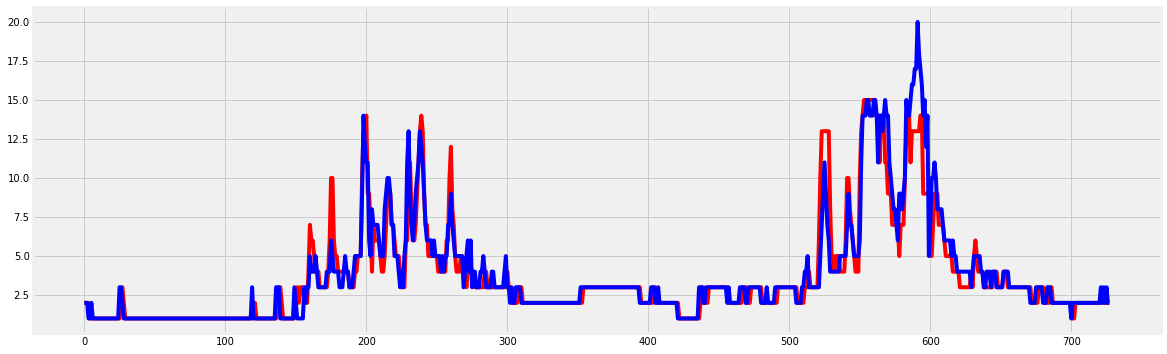

In [814]:
#pt.plot(train_knn_y,c='red')
pt.plot(ypred[:],c='red')
pt.plot(Actuall_inflow[:],c='blue')

In [1008]:
class LocallyWeightedRegression:
    def __init__(self,X,y):
        self.train_x = X
        self.train_y = y

    def fit(self, train_x, train_y):
        LocallyWeightedRegression(train_x,train_y)
        
        
    #locally weighted regression
    
    def lwr1(x0, inp, out, k):
        m,n = np.shape(inp)
        ypred = np.zeros(m)    
        ypred = x0 * beta(x0, inp, out, k)
        #print("The final prediction is :",ypred)
        return ypred

    def beta(point, inp, out, k):
        wt = kernal(point, inp, k)
        #print("The weight of betas is",wt)
        #print("Weight * inp" , (inp.T * (wt*inp)).I)
        out = out.reshape((inp.shape[0],1))
    #     print(inp.shape)
    #     print(wt.shape)
    #     print(out.shape)
        beta_val = (inp.T * (wt*inp)).I * inp.T * wt * out
        #print("The weight is beta value is",beta_val)
        return beta_val

    def kernal(point, inp, k):
        l,b = np.shape(inp)
        weights = np.mat(np.eye((l)))
        #print(weights)    
        for i in range(l):
            #point = point.reshape((point.shape[0],1))
            #print(point.shape,inp[i].shape)
            diff = point - inp[i]
            #print(diff.shape)
            weights[i,i] = np.exp(np.dot(diff,diff.T) / (-2.0 * (k**2)))
        return weights   
    
    def call_Lwr(self, test_x,train_x,train_y,k):
        ypred = []
        for i in test_x:
            ypred.append(lwr1(i, train_x, train_y, k))
        ypred = np.array(ypred).reshape(test_y.shape[0],1)
        ypred = np.round(ypred)
        return ypred

        

    def predict(self, test_x):
        return self.call_Lwr(test_x,train_x,train_y,k=120)  

In [ ]:
lwr = LocallyWeightedRegression(train_x,train_y)
lwr.fit(train_x,train_y)
ypred = lwr.predict(test_x)
ypred

Accuracy =  0.6741573033707865
Accuracy_lag =  0.6741573033707865
F1 Score =  0.803056672311022
Precision =  0.6852055020588252
Recall =  0.6741573033707865
F1 Score_no_lag =  0.6749049111022394


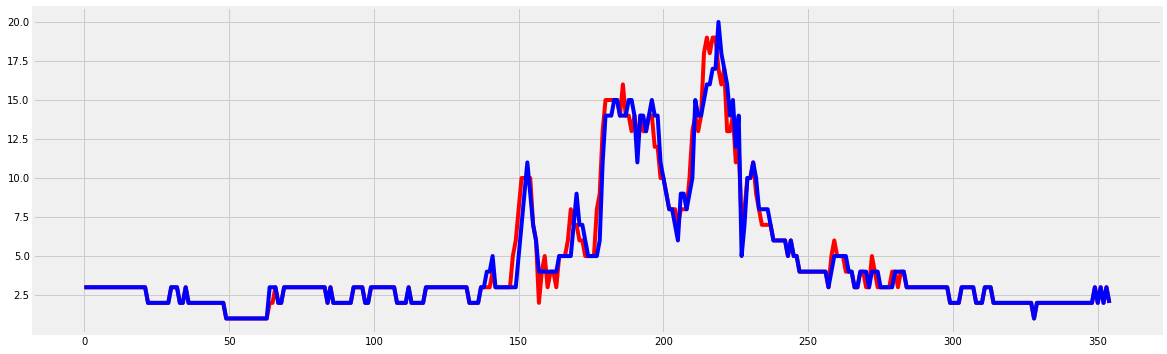

In [980]:
Actuall_inflow=test_y.reshape(test_y.shape[0],1)
print("Accuracy = " ,metrics.accuracy_score(Actuall_inflow,ypred))
print("Accuracy_lag = " ,metrics.accuracy_score(Actuall_inflow[0:],ypred[:]))
#print("Accuracy_knn = " ,metrics.accuracy_score(Actuall_inflow,train_knn_y))
print("F1 Score = ",metrics.f1_score(Actuall_inflow[:-1],ypred[1:],average = 'weighted'))
print("Precision = ",metrics.precision_score(Actuall_inflow[:],ypred[:],average = 'weighted'))
print("Recall = ",metrics.recall_score(Actuall_inflow[:],ypred[:],average = 'weighted'))
print("F1 Score_no_lag = ",metrics.f1_score(Actuall_inflow,ypred,average = 'weighted'))
pt.plot(ypred[1:],c='red')
pt.plot(Actuall_inflow[:-1],c='blue')

In [994]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
#Logistic regression
lr = LogisticRegression(multi_class="multinomial",solver='lbfgs',max_iter=20000)
#lr.fit(train_x,train_y)
#ypred_lr = lr.predict(test_x)

#Gaussian classification
nb = GaussianNB()
#nb.fit(train_x,train_y)
#ypred_nb = nb.predict(test_x)

#LWR
lwr = LocallyWeightedRegression(train_x,train_y)
#lwr.fit(train_x,train_y)
#ypred = lwr.predict(test_x)

#Ensemble
eclf = VotingClassifier(estimators=[('LR',lr), ('GNB', nb), ('LWR', lr)],voting='soft', weights=[1, 1, 3])
# cl1 = nb.fit(train_x,train_y)
# cl2 = lr.fit(train_x,train_y)
eclf = eclf.fit(train_x,train_y)

/home/ganesh/PycharmProjects/untitled1/venv/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ganesh/PycharmProjects/untitled1/venv/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ganesh/PycharmProjects/untitled1/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation fo

F1 Score =  0.7133842282639044
Precision =  0.647406225173079
Recall =  0.6544943820224719
F1 Score_no_lag =  0.6450115013443692


/home/ganesh/PycharmProjects/untitled1/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


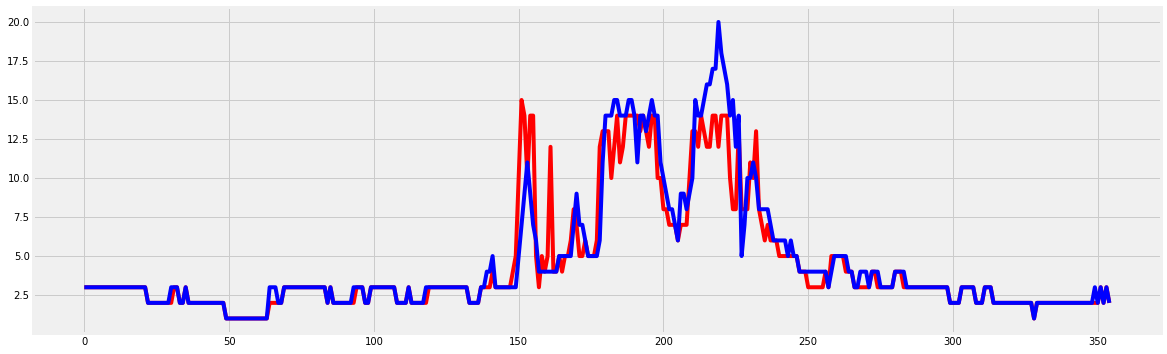

In [995]:
ypred = eclf.predict(test_x)
print("F1 Score = ",metrics.f1_score(Actuall_inflow[:-1],ypred[1:],average = 'weighted'))
print("Precision = ",metrics.precision_score(Actuall_inflow[:],ypred[:],average = 'weighted'))
print("Recall = ",metrics.recall_score(Actuall_inflow[:],ypred[:],average = 'weighted'))
print("F1 Score_no_lag = ",metrics.f1_score(Actuall_inflow,ypred,average = 'weighted'))
pt.plot(ypred[1:],c='red')
pt.plot(Actuall_inflow[:-1],c='blue')

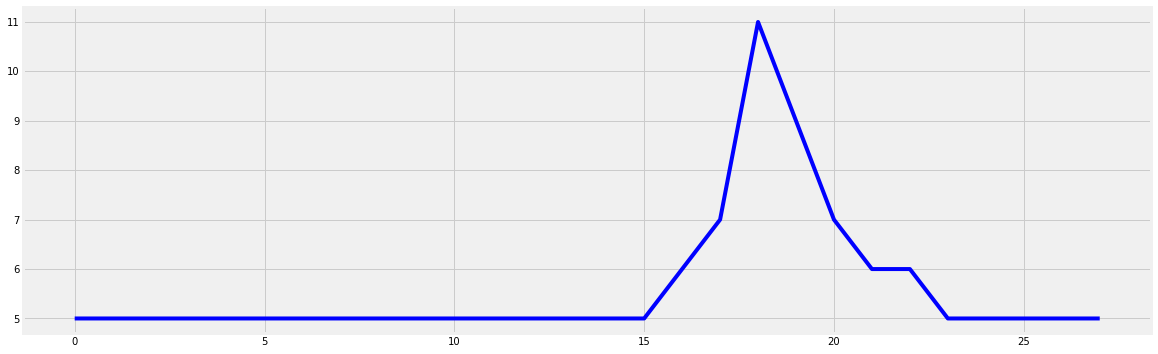

In [565]:
pt.plot(Actuall_inflow,c='blue')

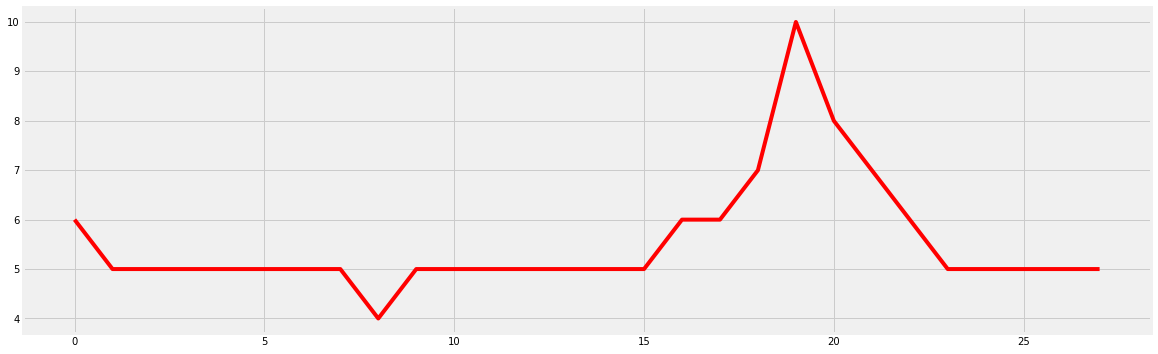

In [566]:
pt.plot(ypred,c='red')

In [155]:
# distance = []
# for single_point in Q_point:
#         #print(single_point)
#         points = inp 
#         #print(points)
#         distance.append(euclid_dist(single_point,points))
# distance
# min_val = np.amin(distance,axis = 0) 
# min_val.shape

In [156]:
# def cal_eucledian_distance(q_point,inp1):
#     #print(q_point,inp1)
#     q_point = list(q_point)
#     #print(q_point.shape)
#     print(inp1.shape)
#     a = np.linalg.norm(q_point - inp1)
#     print(a)

In [157]:
# #for q_point in Q_point:
# abc = cal_eucledian_distance(Q_point[0],inp)

In [158]:
# def knn(inp1,k,q_point):
#     tup_val = []
#     distance_list = [cal_eucledian_distance(Q_point,inp1[i]) for i in range(len(inp1))]
#     #print(distance_list)
#     for i in range(len(inp1)):
#         tup_val.append((distance_list[i],inp1[i]))
#     #print("---------------------------")
#     #print(tup_val)
#     index=0
#     sorted_values = sort(tup_val)
#     neighbours = sorted_values[:k]
#     return neighbours

In [159]:
# def last(n):
#     m =0
#     return n[m]

In [160]:
# def sort(tuples):
#     return sorted(tuples,key=last)

In [19]:
inp1 = t_vals
vals = knn(inp1,10,q_point)
print(vals)
len(vals)

[(20731.981515523323, array([[   42.9525,    31.8   ,    25.085 , 20425.    ]])), (23297.686961347703, array([[2.67125000e+01, 1.83850000e+01, 1.48183333e+01, 1.86060000e+04]])), (24399.328760307188, array([[   47.7375    ,    33.08      ,    35.29666667, 17825.        ]])), (25855.892008067804, array([[   35.975     ,    32.77833333,    24.51333333, 16793.        ]])), (28072.26480699056, array([[   34.2625    ,    21.96833333,    17.76666667, 15223.        ]])), (28472.884040877885, array([[   70.74      ,    52.415     ,    45.90666667, 14939.        ]])), (29992.39079578066, array([[   56.78      ,    41.05      ,    25.89166667, 13863.        ]])), (30037.87962054293, array([[2.85500000e+01, 1.20950000e+01, 1.18066667e+01, 1.38310000e+04]])), (30369.803755501955, array([[2.19325000e+01, 1.40566667e+01, 6.47166667e+00, 1.35960000e+04]])), (30756.227591805935, array([[   77.865     ,    60.06333333,    48.285     , 13322.        ]]))]


10

In [20]:
print(vals[0])

(20731.981515523323, array([[   42.9525,    31.8   ,    25.085 , 20425.    ]]))


In [21]:
near_vals = []
for i in range(len(vals)):
    near_vals.append(vals[i][1])

In [22]:
near_vals = np.array(near_vals)
near_vals.shape

(10, 1, 4)

In [23]:
np.shape(near_vals)

(10, 1, 4)

In [24]:
len(near_vals) 

10

In [25]:
def normalize(mcolB, max_val, min_val):
    #print(mcolB)
    n_val = []
    for i in range(len(mcolB)):
        n_val.append(float(((mcolB[i] - min_val) / (max_val - min_val))))
    return n_val
    #return ( (point - m) / () )

In [26]:
near_vals = np.append(near_vals,[[[123.0475,76.86,78.515,33901]]],axis = 0)
near_vals[:,0:3]


array([[[4.29525000e+01, 3.18000000e+01, 2.50850000e+01, 2.04250000e+04]],

       [[2.67125000e+01, 1.83850000e+01, 1.48183333e+01, 1.86060000e+04]],

       [[4.77375000e+01, 3.30800000e+01, 3.52966667e+01, 1.78250000e+04]],

       [[3.59750000e+01, 3.27783333e+01, 2.45133333e+01, 1.67930000e+04]],

       [[3.42625000e+01, 2.19683333e+01, 1.77666667e+01, 1.52230000e+04]],

       [[7.07400000e+01, 5.24150000e+01, 4.59066667e+01, 1.49390000e+04]],

       [[5.67800000e+01, 4.10500000e+01, 2.58916667e+01, 1.38630000e+04]],

       [[2.85500000e+01, 1.20950000e+01, 1.18066667e+01, 1.38310000e+04]],

       [[2.19325000e+01, 1.40566667e+01, 6.47166667e+00, 1.35960000e+04]],

       [[7.78650000e+01, 6.00633333e+01, 4.82850000e+01, 1.33220000e+04]],

       [[1.23047500e+02, 7.68600000e+01, 7.85150000e+01, 3.39010000e+04]]])

In [27]:
near_len = len(near_vals)
near_len

11

In [28]:
x = near_vals.reshape(near_len,4)

In [29]:
print(len(Dam_data))

2918


In [30]:
mcolA = x[:,0:3]
mcolB = x[:,-1]

In [31]:
mcolA 

array([[ 42.9525    ,  31.8       ,  25.085     ],
       [ 26.7125    ,  18.385     ,  14.81833333],
       [ 47.7375    ,  33.08      ,  35.29666667],
       [ 35.975     ,  32.77833333,  24.51333333],
       [ 34.2625    ,  21.96833333,  17.76666667],
       [ 70.74      ,  52.415     ,  45.90666667],
       [ 56.78      ,  41.05      ,  25.89166667],
       [ 28.55      ,  12.095     ,  11.80666667],
       [ 21.9325    ,  14.05666667,   6.47166667],
       [ 77.865     ,  60.06333333,  48.285     ],
       [123.0475    ,  76.86      ,  78.515     ]])

In [32]:
mcolB

array([20425., 18606., 17825., 16793., 15223., 14939., 13863., 13831.,
       13596., 13322., 33901.])

In [33]:
# a = list(mcolA)
# b = list(mcolB)
# b
# a
inp_matrix = mcolA

In [34]:
# reg_val = []
# mcolB = []
# mcolA = []
# for i in range(len(t_vals)):
#     if t_vals[i][0] in near_vals:
#         reg_val.append((t_vals[i][0],t_vals[i][1]))
#         mcolA.append(t_vals[i][0])
#         mcolB.append(t_vals[i][1])
#         #print("True")
# #print(q_point)
# #print(reg_val)
# print(reg_val)
# size_b = len(mcolB)
# mcolB = np.array(mcolB)
# mcolA = np.array(mcolA)
# mcolB = mcolB.reshape((size_b,1))
# max_val = np.max(mcolB)
# min_val = np.min(mcolB)
# print(np.shape(mcolB))
# print(np.shape(mcolA))
# #print(mcolA1[0])
# print(mcolB)



In [35]:
size_b = len(mcolB)
#print(size_b)
max_val = np.max(mcolB)
min_val = np.min(mcolB)
mcolB = mcolB.reshape(size_b,1)
mcolB.shape

(11, 1)

In [36]:
mcolA.shape

(11, 3)

In [37]:
normalized_tar_val = normalize(mcolB,max_val,min_val)
print(normalized_tar_val)
print(np.max(normalized_tar_val))
normalized_tar_val = np.array(normalized_tar_val)
normalized_tar_val = normalized_tar_val.reshape(size_b,1)
print(np.shape(normalized_tar_val))

[0.3451576850187084, 0.25676660673502116, 0.21881529714757764, 0.16866708780795958, 0.0923757228242383, 0.07857524661062248, 0.026288935322416055, 0.024733952087079063, 0.013314543952573012, 0.0, 1.0]
1.0
(11, 1)


In [38]:
q_point = q_point[:,0:3]
q_point.shape
print(q_point)
q_point[0].shape

[[137.695       57.25        80.23333333]
 [123.0475      76.86        78.515     ]]


(1, 3)

In [39]:
q_point[:,0:4]

matrix([[137.695     ,  57.25      ,  80.23333333],
        [123.0475    ,  76.86      ,  78.515     ]])

In [40]:
def lwr(inp, out, k):
    m,n = np.shape(inp)
    ypred = np.zeros(m)
    
    for i in range(m):
        ypred[i] = inp[i] * beta(inp[i], inp, out, k)
    #print("The final prediction is :",ypred)
    return ypred
    

In [41]:
def lwr1(x0, inp, out, k):
    m,n = np.shape(inp)
    ypred = np.zeros(m)
    
    ypred = x0 * beta(x0, inp, out, k)
    #print("The final prediction is :",ypred)
    return ypred


In [42]:
def beta(point, inp, out, k):
    wt = kernal(point, inp, k)
    #print("The weight of betas is",wt)
    beta_val = (inp.T * (wt*inp)).I * (inp.T * wt * out)
    #print("The weight is beta value is",beta_val)
    
    return beta_val

In [43]:
def kernal(point, inp, k):
    l,b = np.shape(inp)
    weights = np.mat(np.eye((l)))
    #print(weights)
    
    for i in range(l):
        diff = point - inp[i]
        #diff = np.array(diff)
        #print("Hi",len(diff))
        #print(diff.shape)
        #diff = diff.reshape(len(diff),1)
        #print(np.shape(diff))
        #diff1 = diff.T
        #print(np.shape(diff.T))
        #a = np.dot(diff,diff.T)
        #print(a)
        
        #print(a)
        #print(np.shape(a))
        weights[i,i] = np.exp(np.dot(diff,diff.T) / (-2.0 * (k**2)))
        #print(weights[i,i])
    #print("The weights of",i,'is',weights[i,i])
    
    return weights

In [44]:
#mcolB = normalized_tar_val
print(inp_matrix.shape)
print(mcolB.shape)
print(q_point)
print("----------------------")
print(inp_matrix)
print("-----------------------------------------------")
#ypred = lwr(inp_matrix, mcolB, 6)
for i in range(len(q_point)):
    
    ypred1 = lwr1(q_point[i], inp_matrix, mcolB, 1.5)
ypred = np.array(ypred)
print(mcolB)
#print(normalized_tar_val)
#print(ypred)
print("=======================================================")
print(ypred1)
print(np.shape(mcolB))

xsort = inp_matrix.copy()
xsort.sort(axis = 0)
print(np.shape(mcolA))

f, (ax1, ax2) = pt.subplots(1, 2, sharey=True)
pt.plot(xsort[:,1],ypred[mcolA[:,1].argsort(0)],color = 'yellow',linewidth = 5)#ypred[X[:, 1].argsort(0)]
ax1.set_title('Sharing Y axis')
ax2.scatter(mcolA, mcolB)

pt.scatter(mcolA,mcolB,color = 'blue')
pt.plot(xsort[:,1],ypred[mcolA[:,1].argsort(0)],color = 'yellow',linewidth = 5)#ypred[X[:, 1].argsort(0)]
#pt.plot(xsort[:, 1], ypred[X[:, 1].argsort(0)], color='yellow', linewidth=5)
pt.xlabel('MADIKERI')
pt.ylabel('Inflow')

(11, 3)
(11, 1)
[[137.695       57.25        80.23333333]
 [123.0475      76.86        78.515     ]]
----------------------
[[ 42.9525      31.8         25.085     ]
 [ 26.7125      18.385       14.81833333]
 [ 47.7375      33.08        35.29666667]
 [ 35.975       32.77833333  24.51333333]
 [ 34.2625      21.96833333  17.76666667]
 [ 70.74        52.415       45.90666667]
 [ 56.78        41.05        25.89166667]
 [ 28.55        12.095       11.80666667]
 [ 21.9325      14.05666667   6.47166667]
 [ 77.865       60.06333333  48.285     ]
 [123.0475      76.86        78.515     ]]
-----------------------------------------------


LinAlgError: Singular matrix

In [578]:
from sklearn import metrics

In [324]:
metrics.accuracy_score(mcolB, ypred)

ValueError: continuous is not supported

In [974]:
import math
math.sqrt(metrics.mean_squared_error(mcolB,ypred))

ValueError: Found input variables with inconsistent numbers of samples: [12, 25]